In [ ]:
# Problem 1: Continuous Optimization - Ackley Function using Genetic Algorithm

import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from math import exp, cos, pi, sqrt
import time

# Ackley function definition
def ackley_function(x, y):
    """
    Ackley function: f(x,y) = -20*exp(-0.2*sqrt(0.5*(x^2+y^2))) - exp(0.5*(cos(2*pi*x)+cos(2*pi*y))) + e + 20
    Global minimum at (0,0) with value 0
    Domain: [-32, 32] for both x and y
    """
    term1 = -20 * exp(-0.2 * sqrt(0.5 * (x**2 + y**2)))
    term2 = -exp(0.5 * (cos(2 * pi * x) + cos(2 * pi * y)))
    return term1 + term2 + exp(1) + 20

class AckleyGA:
    def __init__(self, pop_size=50, mutation_prob=0.05, max_generations=100, 
                 elite_size=2, crossover_prob=0.8, domain=(-32, 32)):
        self.pop_size = pop_size
        self.mutation_prob = mutation_prob
        self.max_generations = max_generations
        self.elite_size = elite_size
        self.crossover_prob = crossover_prob
        self.domain = domain
        self.population = []
        self.fitness_history = []
        
    def initialize_population(self, seed=None):
        """Initialize random population within domain"""
        if seed:
            np.random.seed(seed)
            random.seed(seed)
        
        self.population = []
        for _ in range(self.pop_size):
            x = np.random.uniform(self.domain[0], self.domain[1])
            y = np.random.uniform(self.domain[0], self.domain[1])
            self.population.append([x, y])
        return self.population
    
    def evaluate_fitness(self, individual):
        """Evaluate fitness (minimize Ackley function)"""
        x, y = individual
        fitness = ackley_function(x, y)
        return fitness
    
    def tournament_selection(self, tournament_size=3):
        """Tournament selection"""
        tournament = random.sample(self.population, tournament_size)
        tournament_fitness = [self.evaluate_fitness(ind) for ind in tournament]
        winner_idx = tournament_fitness.index(min(tournament_fitness))
        return tournament[winner_idx].copy()
    
    def roulette_wheel_selection(self):
        """Roulette wheel selection for minimization"""
        fitness_values = [self.evaluate_fitness(ind) for ind in self.population]
        # Convert to maximization problem for roulette wheel
        max_fitness = max(fitness_values)
        adjusted_fitness = [max_fitness - f + 0.001 for f in fitness_values]
        total_fitness = sum(adjusted_fitness)
        
        if total_fitness == 0:
            return random.choice(self.population).copy()
        
        probabilities = [f / total_fitness for f in adjusted_fitness]
        cumulative_prob = np.cumsum(probabilities)
        
        r = random.random()
        for i, cum_prob in enumerate(cumulative_prob):
            if r <= cum_prob:
                return self.population[i].copy()
        return self.population[-1].copy()
    
    def single_point_crossover(self, parent1, parent2):
        """Single-point crossover for real-valued encoding"""
        if random.random() > self.crossover_prob:
            return parent1.copy(), parent2.copy()
        
        # Single point crossover at gene level (between x and y)
        if random.random() < 0.5:
            child1 = [parent1[0], parent2[1]]
            child2 = [parent2[0], parent1[1]]
        else:
            child1 = parent1.copy()
            child2 = parent2.copy()
        
        return child1, child2
    
    def uniform_crossover(self, parent1, parent2):
        """Uniform crossover for real-valued encoding"""
        if random.random() > self.crossover_prob:
            return parent1.copy(), parent2.copy()
        
        child1, child2 = [], []
        for i in range(len(parent1)):
            if random.random() < 0.5:
                child1.append(parent1[i])
                child2.append(parent2[i])
            else:
                child1.append(parent2[i])
                child2.append(parent1[i])
        
        return child1, child2
    
    def gaussian_mutation(self, individual):
        """Gaussian mutation"""
        mutated = individual.copy()
        for i in range(len(mutated)):
            if random.random() < self.mutation_prob:
                # Gaussian noise with standard deviation of 1
                noise = np.random.normal(0, 1)
                mutated[i] += noise
                # Ensure within domain bounds
                mutated[i] = max(self.domain[0], min(self.domain[1], mutated[i]))
        return mutated
    
    def get_best_individual(self):
        """Get the best individual in current population"""
        fitness_values = [self.evaluate_fitness(ind) for ind in self.population]
        best_idx = fitness_values.index(min(fitness_values))
        return self.population[best_idx].copy(), fitness_values[best_idx]
    
    def run_ga(self, selection_method='tournament', crossover_method='uniform', seed=None, show_initial=False):
        """Run the genetic algorithm"""
        self.initialize_population(seed)
        self.fitness_history = []
        
        # Show initial population and fitness if requested
        if show_initial:
            print(f"\nInitial Population (Seed: {seed}):")
            print("=" * 60)
            initial_fitness = []
            for i, individual in enumerate(self.population[:10]):  # Show first 10
                fitness = self.evaluate_fitness(individual)
                initial_fitness.append(fitness)
                print(f"Individual {i+1:2d}: ({individual[0]:8.4f}, {individual[1]:8.4f}) -> Fitness: {fitness:.6f}")
            
            if len(self.population) > 10:
                print(f"... and {len(self.population) - 10} more individuals")
            
            print(f"\nInitial Population Statistics:")
            all_initial_fitness = [self.evaluate_fitness(ind) for ind in self.population]
            print(f"Best initial fitness: {min(all_initial_fitness):.6f}")
            print(f"Worst initial fitness: {max(all_initial_fitness):.6f}")
            print(f"Mean initial fitness: {np.mean(all_initial_fitness):.6f}")
            print(f"Std deviation: {np.std(all_initial_fitness):.6f}")
            print("-" * 60)
        
        for generation in range(self.max_generations):
            # Evaluate current population
            fitness_values = [self.evaluate_fitness(ind) for ind in self.population]
            best_fitness = min(fitness_values)
            self.fitness_history.append(best_fitness)
            
            # Early stopping if optimal solution found
            if best_fitness < 1e-10:
                break
            
            # Selection and reproduction
            new_population = []
            
            # Elitism: keep best individuals
            elite_indices = sorted(range(len(fitness_values)), key=lambda i: fitness_values[i])[:self.elite_size]
            for idx in elite_indices:
                new_population.append(self.population[idx].copy())
            
            # Generate offspring
            while len(new_population) < self.pop_size:
                # Selection
                if selection_method == 'tournament':
                    parent1 = self.tournament_selection()
                    parent2 = self.tournament_selection()
                else:  # roulette wheel
                    parent1 = self.roulette_wheel_selection()
                    parent2 = self.roulette_wheel_selection()
                
                # Crossover
                if crossover_method == 'uniform':
                    child1, child2 = self.uniform_crossover(parent1, parent2)
                else:  # single point
                    child1, child2 = self.single_point_crossover(parent1, parent2)
                
                # Mutation
                child1 = self.gaussian_mutation(child1)
                child2 = self.gaussian_mutation(child2)
                
                new_population.extend([child1, child2])
            
            # Trim to population size
            self.population = new_population[:self.pop_size]
        
        return self.get_best_individual()

# Experimental setup and execution
def run_ackley_experiments():
    """Run comprehensive experiments for Ackley function optimization"""
    
    # Experimental parameters
    initial_seeds = [42, 123, 456, 789, 999]  # 5 different random starts
    mutation_probs = [0.01, 0.05, 0.1]        # 3 mutation probabilities
    population_sizes = [20, 50, 100]          # 3 population sizes
    max_generations_list = [100, 200, 300]    # 3 stopping criteria
    
    results = []
    experiment_count = 0
    total_experiments = len(initial_seeds) * len(mutation_probs) * len(population_sizes) * len(max_generations_list)
    
    print(f"Running {total_experiments} experiments for Ackley function optimization...")
    start_time = time.time()
    
    for seed in initial_seeds:
        for mut_prob in mutation_probs:
            for pop_size in population_sizes:
                for max_gen in max_generations_list:
                    experiment_count += 1
                    
                    # Create GA instance
                    ga = AckleyGA(
                        pop_size=pop_size,
                        mutation_prob=mut_prob,
                        max_generations=max_gen,
                        elite_size=max(2, pop_size // 10)  # 10% elitism
                    )
                    
                    # Run GA with initial solution display for first few experiments
                    show_initial_solutions = (experiment_count <= 5)  # Show for first 5 experiments
                    
                    # Run GA
                    best_individual, best_fitness = ga.run_ga(
                        selection_method='tournament',
                        crossover_method='uniform',
                        seed=seed,
                        show_initial=show_initial_solutions
                    )
                    
                    # Store results
                    results.append({
                        'Experiment': experiment_count,
                        'Seed': seed,
                        'Mutation_Prob': mut_prob,
                        'Population_Size': pop_size,
                        'Max_Generations': max_gen,
                        'Best_X': best_individual[0],
                        'Best_Y': best_individual[1],
                        'Best_Fitness': best_fitness,
                        'Generations_Run': len(ga.fitness_history)
                    })
                    
                    if experiment_count % 20 == 0:
                        print(f"Completed {experiment_count}/{total_experiments} experiments")
    
    end_time = time.time()
    print(f"All experiments completed in {end_time - start_time:.2f} seconds")
    
    return pd.DataFrame(results)

# Run experiments
results_df = run_ackley_experiments()

# Analysis and Summary
print("\n" + "="*80)
print("ACKLEY FUNCTION GA OPTIMIZATION RESULTS SUMMARY")
print("="*80)

# Display best overall result
best_result = results_df.loc[results_df['Best_Fitness'].idxmin()]
print(f"\nBEST OVERALL RESULT:")
print(f"Best fitness: {best_result['Best_Fitness']:.8f}")
print(f"Best solution: ({best_result['Best_X']:.6f}, {best_result['Best_Y']:.6f})")
print(f"Parameters: Pop_Size={best_result['Population_Size']}, Mut_Prob={best_result['Mutation_Prob']}, Max_Gen={best_result['Max_Generations']}")

# Summary statistics
print(f"\nSUMMARY STATISTICS:")
print(f"Mean fitness: {results_df['Best_Fitness'].mean():.6f}")
print(f"Std deviation: {results_df['Best_Fitness'].std():.6f}")
print(f"Min fitness: {results_df['Best_Fitness'].min():.8f}")
print(f"Max fitness: {results_df['Best_Fitness'].max():.6f}")

# Parameter analysis
print(f"\nPARAMETER ANALYSIS:")

# Mutation probability analysis
mut_analysis = results_df.groupby('Mutation_Prob')['Best_Fitness'].agg(['mean', 'std', 'min']).round(6)
print(f"\nMutation Probability Analysis:")
print(mut_analysis)

# Population size analysis
pop_analysis = results_df.groupby('Population_Size')['Best_Fitness'].agg(['mean', 'std', 'min']).round(6)
print(f"\nPopulation Size Analysis:")
print(pop_analysis)

# Max generations analysis
gen_analysis = results_df.groupby('Max_Generations')['Best_Fitness'].agg(['mean', 'std', 'min']).round(6)
print(f"\nMax Generations Analysis:")
print(gen_analysis)

# Top 10 results
print(f"\nTOP 10 RESULTS:")
top_10 = results_df.nsmallest(10, 'Best_Fitness')[['Mutation_Prob', 'Population_Size', 'Max_Generations', 'Best_X', 'Best_Y', 'Best_Fitness']]
print(top_10.to_string(index=False))

# Success rate (fitness < 0.01)
success_rate = (results_df['Best_Fitness'] < 0.01).mean() * 100
print(f"\nSUCCESS RATE (fitness < 0.01): {success_rate:.1f}%")

# Visualization
plt.figure(figsize=(15, 10))

# Fitness distribution
plt.subplot(2, 3, 1)
plt.hist(results_df['Best_Fitness'], bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Best Fitness')
plt.ylabel('Frequency')
plt.title('Distribution of Best Fitness Values')
plt.yscale('log')

# Mutation probability effect
plt.subplot(2, 3, 2)
mut_means = results_df.groupby('Mutation_Prob')['Best_Fitness'].mean()
plt.bar(mut_means.index.astype(str), mut_means.values, alpha=0.7, edgecolor='black')
plt.xlabel('Mutation Probability')
plt.ylabel('Mean Best Fitness')
plt.title('Effect of Mutation Probability')

# Population size effect
plt.subplot(2, 3, 3)
pop_means = results_df.groupby('Population_Size')['Best_Fitness'].mean()
plt.bar(pop_means.index.astype(str), pop_means.values, alpha=0.7, edgecolor='black')
plt.xlabel('Population Size')
plt.ylabel('Mean Best Fitness')
plt.title('Effect of Population Size')

# Max generations effect
plt.subplot(2, 3, 4)
gen_means = results_df.groupby('Max_Generations')['Best_Fitness'].mean()
plt.bar(gen_means.index.astype(str), gen_means.values, alpha=0.7, edgecolor='black')
plt.xlabel('Max Generations')
plt.ylabel('Mean Best Fitness')
plt.title('Effect of Max Generations')

# Solution distribution
plt.subplot(2, 3, 5)
plt.scatter(results_df['Best_X'], results_df['Best_Y'], alpha=0.5, c=results_df['Best_Fitness'], cmap='viridis')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Distribution of Best Solutions')
plt.colorbar(label='Fitness')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)

# Convergence behavior
plt.subplot(2, 3, 6)
convergence_data = results_df.groupby('Max_Generations')['Generations_Run'].mean()
plt.bar(convergence_data.index.astype(str), convergence_data.values, alpha=0.7, edgecolor='black')
plt.xlabel('Max Generations')
plt.ylabel('Average Generations to Converge')
plt.title('Convergence Behavior')

plt.tight_layout()
plt.show()

# Additional detailed analysis for specific runs
def analyze_specific_ackley_runs():
    """Analyze a few specific runs in detail to show initial and final solutions"""
    print("\n" + "="*80)
    print("DETAILED ANALYSIS OF SPECIFIC ACKLEY RUNS")
    print("="*80)
    
    # Run 3 different examples with detailed output
    seeds_to_analyze = [42, 123, 456]
    
    detailed_histories = []  # Store convergence histories for plotting
    
    for i, seed in enumerate(seeds_to_analyze):
        print(f"\n{'='*50}")
        print(f"DETAILED RUN {i+1} (Seed: {seed})")
        print(f"{'='*50}")
        
        # Create GA instance with moderate parameters
        ga = AckleyGA(
            pop_size=30,
            mutation_prob=0.05,
            max_generations=100,
            elite_size=3
        )
        
        # Initialize population and show initial solutions
        ga.initialize_population(seed)
        
        print("INITIAL POPULATION SAMPLE:")
        print("-" * 50)
        for j, individual in enumerate(ga.population[:5]):  # Show first 5
            fitness = ga.evaluate_fitness(individual)
            print(f"Solution {j+1}: ({individual[0]:8.4f}, {individual[1]:8.4f}) -> Fitness: {fitness:.6f}")
        
        # Show initial statistics
        all_initial_fitness = [ga.evaluate_fitness(ind) for ind in ga.population]
        print("\nINITIAL POPULATION STATISTICS:")
        print(f"Population size: {len(ga.population)}")
        print(f"Best initial fitness: {min(all_initial_fitness):.6f}")
        print(f"Worst initial fitness: {max(all_initial_fitness):.6f}")
        print(f"Mean initial fitness: {np.mean(all_initial_fitness):.6f}")
        print(f"Std deviation: {np.std(all_initial_fitness):.6f}")
        
        # Run the GA (without showing initial again)
        best_individual, best_fitness = ga.run_ga(
            selection_method='tournament',
            crossover_method='uniform',
            seed=None,  # Don't reinitialize
            show_initial=False
        )
        
        # Store convergence history
        detailed_histories.append({
            'seed': seed,
            'history': ga.fitness_history.copy(),
            'best_fitness': best_fitness,
            'best_individual': best_individual
        })
        
        # Show final results
        print("\nFINAL RESULTS:")
        print("-" * 30)
        print(f"Best solution: ({best_individual[0]:.6f}, {best_individual[1]:.6f})")
        print(f"Best fitness: {best_fitness:.8f}")
        print(f"Distance from optimum (0,0): {np.sqrt(best_individual[0]**2 + best_individual[1]**2):.6f}")
        improvement = min(all_initial_fitness) - best_fitness
        improvement_pct = (improvement / min(all_initial_fitness)) * 100 if min(all_initial_fitness) > 0 else 0
        print(f"Improvement: {improvement:.6f} ({improvement_pct:.2f}%)")
        print(f"Generations run: {len(ga.fitness_history)}")
        
        # Show convergence progression
        print("\nCONVERGENCE PROGRESSION:")
        milestones = [0, len(ga.fitness_history)//4, len(ga.fitness_history)//2, 
                     3*len(ga.fitness_history)//4, len(ga.fitness_history)-1]
        for milestone in milestones:
            if milestone < len(ga.fitness_history):
                print(f"Generation {milestone+1:3d}: {ga.fitness_history[milestone]:.6f}")
    
    return detailed_histories

# Run the detailed analysis
detailed_convergence_histories = analyze_specific_ackley_runs()

# Enhanced Visualization with Boxplots and Convergence Plots
plt.figure(figsize=(20, 12))

# 1. Fitness distribution (histogram)
plt.subplot(3, 4, 1)
plt.hist(results_df['Best_Fitness'], bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Best Fitness')
plt.ylabel('Frequency')
plt.title('Distribution of Best Fitness Values')
plt.yscale('log')

# 2. Boxplot for Mutation probability effect
plt.subplot(3, 4, 2)
mutation_probs = sorted(results_df['Mutation_Prob'].unique())
mutation_data = [results_df[results_df['Mutation_Prob'] == mp]['Best_Fitness'].values for mp in mutation_probs]
plt.boxplot(mutation_data, tick_labels=[f'{mp}' for mp in mutation_probs])
plt.xlabel('Mutation Probability')
plt.ylabel('Best Fitness')
plt.title('Mutation Probability Effect (Boxplot)')
plt.yscale('log')

# 3. Boxplot for Population size effect
plt.subplot(3, 4, 3)
pop_sizes = sorted(results_df['Population_Size'].unique())
pop_data = [results_df[results_df['Population_Size'] == ps]['Best_Fitness'].values for ps in pop_sizes]
plt.boxplot(pop_data, tick_labels=[f'{ps}' for ps in pop_sizes])
plt.xlabel('Population Size')
plt.ylabel('Best Fitness')
plt.title('Population Size Effect (Boxplot)')
plt.yscale('log')

# 4. Boxplot for Max generations effect
plt.subplot(3, 4, 4)
max_gens = sorted(results_df['Max_Generations'].unique())
gen_data = [results_df[results_df['Max_Generations'] == mg]['Best_Fitness'].values for mg in max_gens]
plt.boxplot(gen_data, tick_labels=[f'{mg}' for mg in max_gens])
plt.xlabel('Max Generations')
plt.ylabel('Best Fitness')
plt.title('Max Generations Effect (Boxplot)')
plt.yscale('log')

# 5. Solution distribution
plt.subplot(3, 4, 5)
plt.scatter(results_df['Best_X'], results_df['Best_Y'], alpha=0.5, c=results_df['Best_Fitness'], cmap='viridis')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Distribution of Best Solutions')
plt.colorbar(label='Fitness')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)

# 6. Convergence behavior bar plot
plt.subplot(3, 4, 6)
convergence_data = results_df.groupby('Max_Generations')['Generations_Run'].mean()
plt.bar(convergence_data.index.astype(str), convergence_data.values, alpha=0.7, edgecolor='black')
plt.xlabel('Max Generations')
plt.ylabel('Average Generations to Converge')
plt.title('Convergence Behavior')

# 7. Detailed convergence line plots
plt.subplot(3, 4, 7)
colors = ['blue', 'red', 'green']
for i, hist_data in enumerate(detailed_convergence_histories):
    plt.plot(hist_data['history'], color=colors[i], alpha=0.7, 
            label=f"Seed {hist_data['seed']} (Final: {hist_data['best_fitness']:.4f})")
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Convergence Curves (Detailed Runs)')
plt.legend()
plt.yscale('log')

# 8. Fitness improvement over generations (sample runs)
plt.subplot(3, 4, 8)
# Get a few sample runs with different parameters for comparison
sample_params = [
    (0.01, 20, 100),   # Low mutation, small pop
    (0.05, 50, 100),   # Medium mutation, medium pop
    (0.1, 100, 100),   # High mutation, large pop
]

for i, (mut_prob, pop_size, max_gen) in enumerate(sample_params):
    # Run a single GA for demonstration
    ga_sample = AckleyGA(pop_size=pop_size, mutation_prob=mut_prob, max_generations=max_gen)
    best_ind, best_fit = ga_sample.run_ga(seed=42+i)
    
    plt.plot(ga_sample.fitness_history, alpha=0.7, 
            label=f"μ={mut_prob}, N={pop_size}")

plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Convergence Comparison by Parameters')
plt.legend()
plt.yscale('log')

# 9. Performance heatmap
plt.subplot(3, 4, 9)
pivot_table = results_df.groupby(['Mutation_Prob', 'Population_Size'])['Best_Fitness'].mean().unstack()
im = plt.imshow(pivot_table.values, aspect='auto', cmap='viridis')
plt.colorbar(im, label='Mean Best Fitness')
plt.xlabel('Population Size')
plt.ylabel('Mutation Probability')
plt.title('Parameter Interaction Heatmap')
plt.xticks(range(len(pivot_table.columns)), pivot_table.columns)
plt.yticks(range(len(pivot_table.index)), pivot_table.index)

# 10. Success rate by parameters
plt.subplot(3, 4, 10)
success_threshold = 0.01  # Define success as fitness < 0.01
# Fix the pandas deprecation warning
success_by_mut = results_df.groupby('Mutation_Prob')['Best_Fitness'].apply(
    lambda x: (x < success_threshold).mean() * 100
)
plt.bar(success_by_mut.index.astype(str), success_by_mut.values, alpha=0.7, edgecolor='black')
plt.xlabel('Mutation Probability')
plt.ylabel('Success Rate (%)')
plt.title('Success Rate by Mutation Probability')

# 11. Final fitness vs generations scatter
plt.subplot(3, 4, 11)
plt.scatter(results_df['Generations_Run'], results_df['Best_Fitness'], alpha=0.5)
plt.xlabel('Generations Run')
plt.ylabel('Best Fitness')
plt.title('Final Fitness vs Generations')
plt.yscale('log')

# 12. Violin plot for overall performance
plt.subplot(3, 4, 12)
all_fitness_data = [results_df['Best_Fitness'].values]
parts = plt.violinplot(all_fitness_data, positions=[1], showmeans=True, showmedians=True)
plt.xlabel('All Runs')
plt.ylabel('Best Fitness')
plt.title('Overall Performance Distribution')
plt.yscale('log')
plt.xticks([1], ['All Results'])

plt.tight_layout()
plt.show()

print("\nEnhanced visualization completed with boxplots and convergence analysis!")
print(f"Full results DataFrame shape: {results_df.shape}")
print("Ackley function experiment completed successfully!")

Running 135 experiments for Ackley function optimization...

Initial Population (Seed: 42):
Individual  1: ( -8.0294,  28.8457) -> Fitness: 20.259308
Individual  2: ( 14.8476,   6.3141) -> Fitness: 19.580156
Individual  3: (-22.0148, -22.0164) -> Fitness: 19.768230
Individual  4: (-28.2826,  23.4353) -> Fitness: 22.036739
Individual  5: (  6.4714,  13.3166) -> Fitness: 19.755100
Individual  6: (-30.6826,  30.0742) -> Fitness: 21.399682
Individual  7: ( 21.2763, -18.4103) -> Fitness: 21.740690
Individual  8: (-20.3632, -20.2621) -> Fitness: 21.679572
Individual  9: (-12.5285,   1.5844) -> Fitness: 18.968191
Individual 10: ( -4.3555, -13.3613) -> Fitness: 19.444598
... and 10 more individuals

Initial Population Statistics:
Best initial fitness: 17.808323
Worst initial fitness: 22.036739
Mean initial fitness: 20.323509
Std deviation: 1.094430
------------------------------------------------------------

Initial Population (Seed: 42):
Individual  1: ( -8.0294,  28.8457) -> Fitness: 20.259

Running 135 experiments for QAP optimization...

Initial Population (Seed: 42):
Individual  1: [8, 13, 7, 6, 14, 12, 5, 2, 9, 3, 4, 11, 0, 1, 10] -> Cost: 848
Individual  2: [2, 12, 9, 7, 4, 6, 5, 10, 13, 8, 11, 3, 1, 14, 0] -> Cost: 928
Individual  3: [7, 8, 3, 11, 10, 14, 1, 13, 5, 6, 2, 0, 12, 4, 9] -> Cost: 880
Individual  4: [12, 8, 6, 2, 10, 11, 3, 14, 7, 0, 4, 9, 13, 5, 1] -> Cost: 952
Individual  5: [8, 2, 5, 14, 10, 7, 6, 12, 4, 13, 0, 1, 11, 3, 9] -> Cost: 828
Individual  6: [8, 7, 11, 1, 0, 6, 9, 4, 3, 14, 12, 2, 5, 13, 10] -> Cost: 940
Individual  7: [9, 14, 11, 13, 1, 0, 12, 5, 3, 8, 10, 4, 6, 7, 2] -> Cost: 986
Individual  8: [14, 8, 0, 2, 13, 11, 10, 6, 7, 12, 5, 9, 3, 1, 4] -> Cost: 956
Individual  9: [7, 2, 0, 3, 14, 12, 1, 5, 10, 6, 9, 4, 13, 8, 11] -> Cost: 960
Individual 10: [8, 0, 5, 11, 7, 4, 3, 9, 14, 6, 12, 10, 2, 1, 13] -> Cost: 906
... and 10 more individuals

Initial Population Statistics:
Best initial cost: 828
Worst initial cost: 986
Mean initial cost: 916.

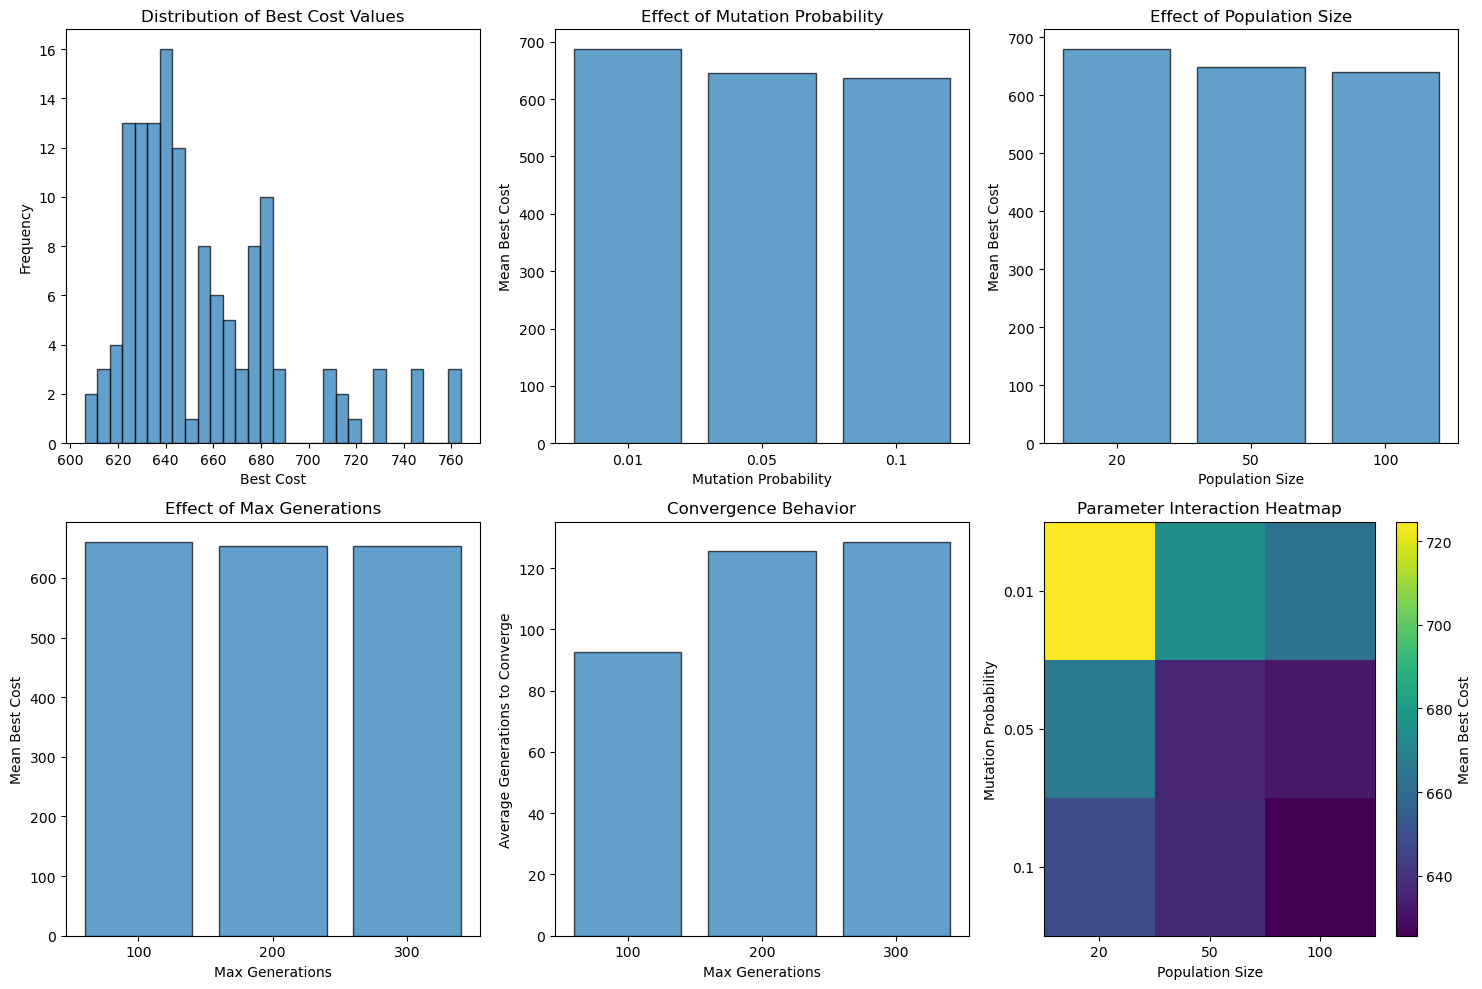


BEST PERMUTATION ANALYSIS:
Best permutation: [10, 11, 5, 6, 9, 4, 1, 7, 3, 13, 0, 12, 8, 2, 14]
Verification - Total cost: 606
Cost matches: True

EFFICIENCY ANALYSIS:
Cost range: 158
Coefficient of variation: 0.0526
Success rate (within 10% of best): 70.4%

DETAILED ANALYSIS OF SPECIFIC RUNS

DETAILED RUN 1 (Seed: 42)
INITIAL POPULATION SAMPLE:
--------------------------------------------------
Solution 1: [8, 13, 7, 6, 14, 12, 5, 2, 9, 3, 4, 11, 0, 1, 10]
Cost: 848

Solution 2: [2, 12, 9, 7, 4, 6, 5, 10, 13, 8, 11, 3, 1, 14, 0]
Cost: 928

Solution 3: [7, 8, 3, 11, 10, 14, 1, 13, 5, 6, 2, 0, 12, 4, 9]
Cost: 880

Solution 4: [12, 8, 6, 2, 10, 11, 3, 14, 7, 0, 4, 9, 13, 5, 1]
Cost: 952

Solution 5: [8, 2, 5, 14, 10, 7, 6, 12, 4, 13, 0, 1, 11, 3, 9]
Cost: 828

INITIAL POPULATION STATISTICS:
Population size: 30
Best initial cost: 828
Worst initial cost: 1018
Mean initial cost: 923.93
Std deviation: 51.49

FINAL RESULTS:
------------------------------
Best solution: [8, 9, 10, 11, 3, 0, 1

In [1]:
# Problem 2: Combinatorial Optimization - Quadratic Assignment Problem (QAP) using Genetic Algorithm

import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import time

class QAP_GA:
    def __init__(self, distance_matrix, flow_matrix, pop_size=50, mutation_prob=0.05, 
                 max_generations=100, elite_size=2, crossover_prob=0.8):
        self.distance_matrix = np.array(distance_matrix)
        self.flow_matrix = np.array(flow_matrix)
        self.n_facilities = len(distance_matrix)
        self.pop_size = pop_size
        self.mutation_prob = mutation_prob
        self.max_generations = max_generations
        self.elite_size = elite_size
        self.crossover_prob = crossover_prob
        self.population = []
        self.fitness_history = []
        
    def initialize_population(self, seed=None):
        """Initialize random population of permutations"""
        if seed:
            random.seed(seed)
            np.random.seed(seed)
        
        self.population = []
        base_permutation = list(range(self.n_facilities))
        
        for _ in range(self.pop_size):
            permutation = base_permutation.copy()
            random.shuffle(permutation)
            self.population.append(permutation)
        
        return self.population
    
    def evaluate_fitness(self, permutation):
        """Calculate QAP objective function value for a permutation"""
        total_cost = 0
        for i in range(self.n_facilities):
            for j in range(self.n_facilities):
                if i != j:
                    facility_i = permutation[i]
                    facility_j = permutation[j]
                    # Cost = flow between facilities * distance between locations
                    cost = self.flow_matrix[facility_i][facility_j] * self.distance_matrix[i][j]
                    total_cost += cost
        return total_cost
    
    def tournament_selection(self, tournament_size=3):
        """Tournament selection for minimization"""
        tournament = random.sample(self.population, tournament_size)
        tournament_fitness = [self.evaluate_fitness(perm) for perm in tournament]
        winner_idx = tournament_fitness.index(min(tournament_fitness))
        return tournament[winner_idx].copy()
    
    def roulette_wheel_selection(self):
        """Roulette wheel selection adapted for minimization"""
        fitness_values = [self.evaluate_fitness(perm) for perm in self.population]
        # Convert to maximization problem
        max_fitness = max(fitness_values)
        adjusted_fitness = [max_fitness - f + 1 for f in fitness_values]
        total_fitness = sum(adjusted_fitness)
        
        if total_fitness == 0:
            return random.choice(self.population).copy()
        
        probabilities = [f / total_fitness for f in adjusted_fitness]
        cumulative_prob = np.cumsum(probabilities)
        
        r = random.random()
        for i, cum_prob in enumerate(cumulative_prob):
            if r <= cum_prob:
                return self.population[i].copy()
        return self.population[-1].copy()
    
    def order_crossover(self, parent1, parent2):
        """Order Crossover (OX) for permutations"""
        if random.random() > self.crossover_prob:
            return parent1.copy(), parent2.copy()
        
        size = len(parent1)
        # Choose two random crossover points
        start = random.randint(0, size - 2)
        end = random.randint(start + 1, size - 1)
        
        # Initialize children
        child1 = [-1] * size
        child2 = [-1] * size
        
        # Copy the substring from parent1 to child1 and parent2 to child2
        child1[start:end+1] = parent1[start:end+1]
        child2[start:end+1] = parent2[start:end+1]
        
        # Fill remaining positions
        self._fill_ox_child(child1, parent2, start, end)
        self._fill_ox_child(child2, parent1, start, end)
        
        return child1, child2
    
    def _fill_ox_child(self, child, parent, start, end):
        """Helper function for Order Crossover"""
        size = len(child)
        parent_idx = (end + 1) % size
        child_idx = (end + 1) % size
        
        while -1 in child:
            if parent[parent_idx] not in child:
                child[child_idx] = parent[parent_idx]
                child_idx = (child_idx + 1) % size
            parent_idx = (parent_idx + 1) % size
    
    def partially_mapped_crossover(self, parent1, parent2):
        """Partially Mapped Crossover (PMX) for permutations"""
        if random.random() > self.crossover_prob:
            return parent1.copy(), parent2.copy()
        
        size = len(parent1)
        # Choose two random crossover points
        start = random.randint(0, size - 2)
        end = random.randint(start + 1, size - 1)
        
        # Initialize children as copies of parents
        child1 = parent1.copy()
        child2 = parent2.copy()
        
        # Create mapping from the crossover segment
        mapping1 = {}  # parent2 -> parent1 mapping
        mapping2 = {}  # parent1 -> parent2 mapping
        
        for i in range(start, end + 1):
            mapping1[parent2[i]] = parent1[i]
            mapping2[parent1[i]] = parent2[i]
            child1[i] = parent2[i]
            child2[i] = parent1[i]
        
        # Fix conflicts outside the crossover segment
        for i in range(size):
            if i < start or i > end:
                # Fix child1
                while child1[i] in child1[start:end+1]:
                    child1[i] = mapping1.get(child1[i], child1[i])
                
                # Fix child2
                while child2[i] in child2[start:end+1]:
                    child2[i] = mapping2.get(child2[i], child2[i])
        
        return child1, child2
    
    def two_opt_mutation(self, permutation):
        """2-opt swap mutation for permutations"""
        mutated = permutation.copy()
        
        if random.random() < self.mutation_prob:
            # Choose two random positions
            i = random.randint(0, len(mutated) - 1)
            j = random.randint(0, len(mutated) - 1)
            
            # Ensure i != j
            while i == j:
                j = random.randint(0, len(mutated) - 1)
            
            # Swap elements at positions i and j
            mutated[i], mutated[j] = mutated[j], mutated[i]
        
        return mutated
    
    def get_best_individual(self):
        """Get the best individual in current population"""
        fitness_values = [self.evaluate_fitness(perm) for perm in self.population]
        best_idx = fitness_values.index(min(fitness_values))
        return self.population[best_idx].copy(), fitness_values[best_idx]
    
    def run_ga(self, selection_method='tournament', crossover_method='ox', seed=None, show_initial=False):
        """Run the genetic algorithm"""
        self.initialize_population(seed)
        self.fitness_history = []
        
        # Show initial population and costs if requested
        if show_initial:
            print(f"\nInitial Population (Seed: {seed}):")
            print("=" * 60)
            initial_costs = []
            for i, individual in enumerate(self.population[:10]):  # Show first 10
                cost = self.evaluate_fitness(individual)
                initial_costs.append(cost)
                print(f"Individual {i+1:2d}: {individual} -> Cost: {cost}")
            
            if len(self.population) > 10:
                print(f"... and {len(self.population) - 10} more individuals")
            
            print(f"\nInitial Population Statistics:")
            print(f"Best initial cost: {min(initial_costs)}")
            print(f"Worst initial cost: {max(initial_costs)}")
            print(f"Mean initial cost: {np.mean([self.evaluate_fitness(ind) for ind in self.population]):.2f}")
            print("-" * 60)
        
        best_fitness_unchanged = 0
        previous_best = float('inf')
        
        for generation in range(self.max_generations):
            # Evaluate current population
            fitness_values = [self.evaluate_fitness(perm) for perm in self.population]
            best_fitness = min(fitness_values)
            self.fitness_history.append(best_fitness)
            
            # Check for convergence
            if best_fitness == previous_best:
                best_fitness_unchanged += 1
                if best_fitness_unchanged >= 50:  # Stop if no improvement for 50 generations
                    break
            else:
                best_fitness_unchanged = 0
                previous_best = best_fitness
            
            # Selection and reproduction
            new_population = []
            
            # Elitism: keep best individuals
            elite_indices = sorted(range(len(fitness_values)), key=lambda i: fitness_values[i])[:self.elite_size]
            for idx in elite_indices:
                new_population.append(self.population[idx].copy())
            
            # Generate offspring
            while len(new_population) < self.pop_size:
                # Selection
                if selection_method == 'tournament':
                    parent1 = self.tournament_selection()
                    parent2 = self.tournament_selection()
                else:  # roulette wheel
                    parent1 = self.roulette_wheel_selection()
                    parent2 = self.roulette_wheel_selection()
                
                # Crossover
                if crossover_method == 'ox':
                    child1, child2 = self.order_crossover(parent1, parent2)
                else:  # PMX
                    child1, child2 = self.partially_mapped_crossover(parent1, parent2)
                
                # Mutation
                child1 = self.two_opt_mutation(child1)
                child2 = self.two_opt_mutation(child2)
                
                new_population.extend([child1, child2])
            
            # Trim to population size
            self.population = new_population[:self.pop_size]
        
        return self.get_best_individual()

# QAP Data for 15 departments (from typical benchmark problems)
def get_qap_15_data():
    """Generate or load QAP data for 15 departments"""
    
    # Distance matrix (15x15) - represents distances between locations
    distance_matrix = [
        [0, 1, 2, 3, 1, 2, 3, 4, 2, 3, 4, 5, 3, 4, 5],
        [1, 0, 1, 2, 2, 1, 2, 3, 3, 2, 3, 4, 4, 3, 4],
        [2, 1, 0, 1, 3, 2, 1, 2, 4, 3, 2, 3, 5, 4, 3],
        [3, 2, 1, 0, 4, 3, 2, 1, 5, 4, 3, 2, 6, 5, 4],
        [1, 2, 3, 4, 0, 1, 2, 3, 1, 2, 3, 4, 2, 3, 4],
        [2, 1, 2, 3, 1, 0, 1, 2, 2, 1, 2, 3, 3, 2, 3],
        [3, 2, 1, 2, 2, 1, 0, 1, 3, 2, 1, 2, 4, 3, 2],
        [4, 3, 2, 1, 3, 2, 1, 0, 4, 3, 2, 1, 5, 4, 3],
        [2, 3, 4, 5, 1, 2, 3, 4, 0, 1, 2, 3, 1, 2, 3],
        [3, 2, 3, 4, 2, 1, 2, 3, 1, 0, 1, 2, 2, 1, 2],
        [4, 3, 2, 3, 3, 2, 1, 2, 2, 1, 0, 1, 3, 2, 1],
        [5, 4, 3, 2, 4, 3, 2, 1, 3, 2, 1, 0, 4, 3, 2],
        [3, 4, 5, 6, 2, 3, 4, 5, 1, 2, 3, 4, 0, 1, 2],
        [4, 3, 4, 5, 3, 2, 3, 4, 2, 1, 2, 3, 1, 0, 1],
        [5, 4, 3, 4, 4, 3, 2, 3, 3, 2, 1, 2, 2, 1, 0]
    ]
    
    # Flow matrix (15x15) - represents flow/interaction between departments
    flow_matrix = [
        [0, 5, 2, 4, 1, 0, 0, 6, 2, 1, 1, 1, 1, 1, 1],
        [5, 0, 3, 0, 2, 6, 2, 6, 1, 1, 1, 1, 1, 0, 1],
        [2, 3, 0, 3, 0, 0, 0, 0, 5, 1, 1, 1, 1, 5, 1],
        [4, 0, 3, 0, 0, 0, 0, 0, 5, 2, 2, 2, 2, 10, 2],
        [1, 2, 0, 0, 0, 10, 0, 0, 0, 5, 1, 1, 1, 5, 1],
        [0, 6, 0, 0, 10, 0, 10, 0, 0, 0, 5, 1, 1, 1, 5],
        [0, 2, 0, 0, 0, 10, 0, 10, 0, 0, 0, 5, 5, 1, 1],
        [6, 6, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 5, 1, 1],
        [2, 1, 5, 5, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 2, 5, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
        [1, 1, 1, 2, 1, 5, 0, 0, 0, 1, 0, 1, 0, 0, 0],
        [1, 1, 1, 2, 1, 1, 5, 0, 0, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 2, 1, 1, 5, 5, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 5, 10, 5, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1],
        [1, 1, 1, 2, 1, 5, 1, 1, 0, 0, 0, 0, 0, 1, 0]
    ]
    
    return distance_matrix, flow_matrix

# Experimental setup and execution
def run_qap_experiments():
    """Run comprehensive experiments for QAP optimization"""
    
    # Get QAP data
    distance_matrix, flow_matrix = get_qap_15_data()
    
    # Experimental parameters
    initial_seeds = [42, 123, 456, 789, 999]  # 5 different random starts
    mutation_probs = [0.01, 0.05, 0.1]        # 3 mutation probabilities
    population_sizes = [20, 50, 100]          # 3 population sizes
    max_generations_list = [100, 200, 300]    # 3 stopping criteria
    
    results = []
    experiment_count = 0
    total_experiments = len(initial_seeds) * len(mutation_probs) * len(population_sizes) * len(max_generations_list)
    
    print(f"Running {total_experiments} experiments for QAP optimization...")
    start_time = time.time()
    
    for seed in initial_seeds:
        for mut_prob in mutation_probs:
            for pop_size in population_sizes:
                for max_gen in max_generations_list:
                    experiment_count += 1
                    
                    # Create GA instance
                    ga = QAP_GA(
                        distance_matrix=distance_matrix,
                        flow_matrix=flow_matrix,
                        pop_size=pop_size,
                        mutation_prob=mut_prob,
                        max_generations=max_gen,
                        elite_size=max(2, pop_size // 10)  # 10% elitism
                    )
                    
                    # Run GA with initial solution display for first few experiments
                    show_initial_solutions = (experiment_count <= 5)  # Show for first 5 experiments
                    
                    best_permutation, best_cost = ga.run_ga(
                        selection_method='tournament',
                        crossover_method='ox',
                        seed=seed,
                        show_initial=show_initial_solutions
                    )
                    
                    # Store results
                    results.append({
                        'Experiment': experiment_count,
                        'Seed': seed,
                        'Mutation_Prob': mut_prob,
                        'Population_Size': pop_size,
                        'Max_Generations': max_gen,
                        'Best_Permutation': best_permutation,
                        'Best_Cost': best_cost,
                        'Generations_Run': len(ga.fitness_history)
                    })
                    
                    if experiment_count % 20 == 0:
                        print(f"Completed {experiment_count}/{total_experiments} experiments")
    
    end_time = time.time()
    print(f"All experiments completed in {end_time - start_time:.2f} seconds")
    
    return pd.DataFrame(results)

# Run experiments
results_df = run_qap_experiments()

# Analysis and Summary
print("\n" + "="*80)
print("QAP (15 DEPARTMENTS) GA OPTIMIZATION RESULTS SUMMARY")
print("="*80)

# Display best overall result
best_result = results_df.loc[results_df['Best_Cost'].idxmin()]
print(f"\nBEST OVERALL RESULT:")
print(f"Best cost: {best_result['Best_Cost']}")
print(f"Best permutation: {best_result['Best_Permutation']}")
print(f"Parameters: Pop_Size={best_result['Population_Size']}, Mut_Prob={best_result['Mutation_Prob']}, Max_Gen={best_result['Max_Generations']}")

# Summary statistics
print(f"\nSUMMARY STATISTICS:")
print(f"Mean cost: {results_df['Best_Cost'].mean():.2f}")
print(f"Std deviation: {results_df['Best_Cost'].std():.2f}")
print(f"Min cost: {results_df['Best_Cost'].min()}")
print(f"Max cost: {results_df['Best_Cost'].max()}")

# Parameter analysis
print(f"\nPARAMETER ANALYSIS:")

# Mutation probability analysis
mut_analysis = results_df.groupby('Mutation_Prob')['Best_Cost'].agg(['mean', 'std', 'min']).round(2)
print(f"\nMutation Probability Analysis:")
print(mut_analysis)

# Population size analysis
pop_analysis = results_df.groupby('Population_Size')['Best_Cost'].agg(['mean', 'std', 'min']).round(2)
print(f"\nPopulation Size Analysis:")
print(pop_analysis)

# Max generations analysis
gen_analysis = results_df.groupby('Max_Generations')['Best_Cost'].agg(['mean', 'std', 'min']).round(2)
print(f"\nMax Generations Analysis:")
print(gen_analysis)

# Top 10 results
print(f"\nTOP 10 RESULTS:")
top_10 = results_df.nsmallest(10, 'Best_Cost')[['Mutation_Prob', 'Population_Size', 'Max_Generations', 'Best_Cost', 'Generations_Run']]
print(top_10.to_string(index=False))

# Convergence analysis
avg_generations = results_df['Generations_Run'].mean()
print(f"\nCONVERGENCE ANALYSIS:")
print(f"Average generations to convergence: {avg_generations:.1f}")

# Performance by parameter combinations
print(f"\nBEST PARAMETER COMBINATIONS:")
param_performance = results_df.groupby(['Mutation_Prob', 'Population_Size', 'Max_Generations'])['Best_Cost'].min().reset_index()
best_params = param_performance.nsmallest(5, 'Best_Cost')
print(best_params.to_string(index=False))

# Visualization
plt.figure(figsize=(15, 10))

# Cost distribution
plt.subplot(2, 3, 1)
plt.hist(results_df['Best_Cost'], bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Best Cost')
plt.ylabel('Frequency')
plt.title('Distribution of Best Cost Values')

# Mutation probability effect
plt.subplot(2, 3, 2)
mut_means = results_df.groupby('Mutation_Prob')['Best_Cost'].mean()
plt.bar(mut_means.index.astype(str), mut_means.values, alpha=0.7, edgecolor='black')
plt.xlabel('Mutation Probability')
plt.ylabel('Mean Best Cost')
plt.title('Effect of Mutation Probability')

# Population size effect
plt.subplot(2, 3, 3)
pop_means = results_df.groupby('Population_Size')['Best_Cost'].mean()
plt.bar(pop_means.index.astype(str), pop_means.values, alpha=0.7, edgecolor='black')
plt.xlabel('Population Size')
plt.ylabel('Mean Best Cost')
plt.title('Effect of Population Size')

# Max generations effect
plt.subplot(2, 3, 4)
gen_means = results_df.groupby('Max_Generations')['Best_Cost'].mean()
plt.bar(gen_means.index.astype(str), gen_means.values, alpha=0.7, edgecolor='black')
plt.xlabel('Max Generations')
plt.ylabel('Mean Best Cost')
plt.title('Effect of Max Generations')

# Convergence behavior
plt.subplot(2, 3, 5)
convergence_data = results_df.groupby('Max_Generations')['Generations_Run'].mean()
plt.bar(convergence_data.index.astype(str), convergence_data.values, alpha=0.7, edgecolor='black')
plt.xlabel('Max Generations')
plt.ylabel('Average Generations to Converge')
plt.title('Convergence Behavior')

# Parameter interaction heatmap
plt.subplot(2, 3, 6)
pivot_table = results_df.groupby(['Mutation_Prob', 'Population_Size'])['Best_Cost'].mean().unstack()
plt.imshow(pivot_table.values, aspect='auto', cmap='viridis')
plt.colorbar(label='Mean Best Cost')
plt.xlabel('Population Size')
plt.ylabel('Mutation Probability')
plt.title('Parameter Interaction Heatmap')
plt.xticks(range(len(pivot_table.columns)), pivot_table.columns)
plt.yticks(range(len(pivot_table.index)), pivot_table.index)

plt.tight_layout()
plt.show()

# Additional analysis: Best permutation analysis
print(f"\nBEST PERMUTATION ANALYSIS:")
best_perm = best_result['Best_Permutation']
print(f"Best permutation: {best_perm}")

# Calculate some statistics about the best permutation
distance_matrix, flow_matrix = get_qap_15_data()
total_flow_distance = 0
for i in range(15):
    for j in range(15):
        if i != j:
            facility_i = best_perm[i]
            facility_j = best_perm[j]
            flow_distance = flow_matrix[facility_i][facility_j] * distance_matrix[i][j]
            total_flow_distance += flow_distance

print(f"Verification - Total cost: {total_flow_distance}")
print(f"Cost matches: {total_flow_distance == best_result['Best_Cost']}")

# Efficiency analysis
print(f"\nEFFICIENCY ANALYSIS:")
print(f"Cost range: {results_df['Best_Cost'].max() - results_df['Best_Cost'].min()}")
print(f"Coefficient of variation: {(results_df['Best_Cost'].std() / results_df['Best_Cost'].mean()):.4f}")

# Success rate analysis (define success as being within 10% of best solution)
best_cost = results_df['Best_Cost'].min()
success_threshold = best_cost * 1.10
success_rate = (results_df['Best_Cost'] <= success_threshold).mean() * 100
print(f"Success rate (within 10% of best): {success_rate:.1f}%")

# Additional detailed analysis for specific runs
def analyze_specific_runs():
    """Analyze a few specific runs in detail to show initial and final solutions"""
    print("\n" + "="*80)
    print("DETAILED ANALYSIS OF SPECIFIC RUNS")
    print("="*80)
    
    distance_matrix, flow_matrix = get_qap_15_data()
    
    # Run 3 different examples with detailed output
    seeds_to_analyze = [42, 123, 456]
    
    for i, seed in enumerate(seeds_to_analyze):
        print(f"\n{'='*50}")
        print(f"DETAILED RUN {i+1} (Seed: {seed})")
        print(f"{'='*50}")
        
        # Create GA instance with moderate parameters
        ga = QAP_GA(
            distance_matrix=distance_matrix,
            flow_matrix=flow_matrix,
            pop_size=30,
            mutation_prob=0.05,
            max_generations=100,
            elite_size=3
        )
        
        # Initialize population and show initial solutions
        ga.initialize_population(seed)
        
        print("INITIAL POPULATION SAMPLE:")
        print("-" * 50)
        initial_costs = []
        for j, individual in enumerate(ga.population[:5]):  # Show first 5
            cost = ga.evaluate_fitness(individual)
            initial_costs.append(cost)
            print(f"Solution {j+1}: {individual}")
            print(f"Cost: {cost}")
            print()
        
        # Show initial statistics
        all_initial_costs = [ga.evaluate_fitness(ind) for ind in ga.population]
        print("INITIAL POPULATION STATISTICS:")
        print(f"Population size: {len(ga.population)}")
        print(f"Best initial cost: {min(all_initial_costs)}")
        print(f"Worst initial cost: {max(all_initial_costs)}")
        print(f"Mean initial cost: {np.mean(all_initial_costs):.2f}")
        print(f"Std deviation: {np.std(all_initial_costs):.2f}")
        
        # Run the GA (without showing initial again)
        best_permutation, best_cost = ga.run_ga(
            selection_method='tournament',
            crossover_method='ox',
            seed=None,  # Don't reinitialize
            show_initial=False
        )
        
        # Show final results
        print("\nFINAL RESULTS:")
        print("-" * 30)
        print(f"Best solution: {best_permutation}")
        print(f"Best cost: {best_cost}")
        print(f"Improvement: {min(all_initial_costs) - best_cost} ({((min(all_initial_costs) - best_cost) / min(all_initial_costs) * 100):.2f}%)")
        print(f"Generations run: {len(ga.fitness_history)}")
        
        # Show convergence progression
        print("\nCONVERGENCE PROGRESSION:")
        milestones = [0, len(ga.fitness_history)//4, len(ga.fitness_history)//2, 
                     3*len(ga.fitness_history)//4, len(ga.fitness_history)-1]
        for milestone in milestones:
            if milestone < len(ga.fitness_history):
                print(f"Generation {milestone+1:3d}: {ga.fitness_history[milestone]:.2f}")

# Run the detailed analysis
analyze_specific_runs()

print(f"\nFull results DataFrame shape: {results_df.shape}")
print("QAP experiment completed successfully!")